In [ ]:
import torch
import torch.nn as nn
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from scipy import io

# 数据加载

第一个代码块用于加载数据，第二个用于构建数据集，生成一个列表

In [127]:
data_train = io.loadmat('data.mat')["trajectory_train"].T
data_test = io.loadmat('data.mat')["trajectory_test"].T
train_data0 = torch.tensor(data_train[0], dtype=torch.float32)

In [3]:
train_window = 1 # 每次训练的个数
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L - tw):
        train_seq = input_data[i: i + tw]
        train_label = input_data[i + tw]
        inout_seq.append((train_seq, train_label))
    return inout_seq

In [4]:
train_inout_seq = []
for i in range(10):
    train_data0 = torch.tensor(data_train[i], dtype=torch.float32)
    train_inout_seq += create_inout_sequences(train_data0, train_window)

In [5]:
len(train_inout_seq)

100000

# 模型构建
data_generator是一个基于torch.utils.data.Dataset写的继承类，用于构建训练数据；



In [130]:
class data_generator(Dataset):
    def __init__(self, train_inout_seq: list) -> None:
        super().__init__()
        self.data = train_inout_seq
    
    def __getitem__(self, index):
        return self.data[index][0], self.data[index][1]
    
    def __len__(self):
        return len(self.data)

data_gen = data_generator(train_inout_seq = train_inout_seq)

dataset = DataLoader(dataset = data_gen,
                     batch_size = 64,
                     shuffle=True)

class DenseNet(nn.Module):
    def __init__(self, input_size, out_size, seq_length) -> None:
        super().__init__()
        self.input_size = input_size
        self.out_size = out_size
        self.padding = 2
        self.conv = nn.Conv1d(in_channels = input_size, 
                      out_channels = input_size * 2,
                      padding = 2,
                      kernel_size = 3)
        
        self.flatten = nn.Flatten()
        self.nnBlock = nn.Sequential(
            nn.Linear((seq_length - 3 + 1 + self.padding * 2) * input_size * 2,
                      (seq_length - 3 + 1 + self.padding * 2) * input_size * 2),
            nn.Tanh(),
            nn.Linear((seq_length - 3 + 1 + self.padding * 2) * input_size * 2,
                      (seq_length - 3 + 1 + self.padding * 2) * input_size * 2),
            nn.Tanh(),
            nn.Linear((seq_length - 3 + 1 + self.padding * 2) * input_size * 2,
                      (seq_length - 3 + 1 + self.padding * 2) * input_size * 2),
            nn.ReLU()
        )
        
        self.linear = nn.Linear((seq_length - 3 + 1 + 2 * 2) * input_size * 2, out_size)
        
    def forward(self, input):
        input = input.transpose(-2, -1)
        fx = self.conv(input)
        fx = self.flatten(fx)
        fx2 = self.nnBlock(fx)
        fx3 = self.nnBlock(fx+fx2)
        return self.linear(fx+fx2+fx3)

In [133]:
densenet = DenseNet(3, 3, train_window)
print(densenet)

DenseNet(
  (conv): Conv1d(3, 6, kernel_size=(3,), stride=(1,), padding=(2,))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (nnBlock): Sequential(
    (0): Linear(in_features=18, out_features=18, bias=True)
    (1): Tanh()
    (2): Linear(in_features=18, out_features=18, bias=True)
    (3): Tanh()
    (4): Linear(in_features=18, out_features=18, bias=True)
    (5): ReLU()
  )
  (linear): Linear(in_features=18, out_features=3, bias=True)
)


In [137]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(params=densenet.parameters(), lr=2e-8)
dataset = DataLoader(dataset = data_gen,
                     batch_size = 100000,
                     shuffle=True)
epochs = 50
for epoch in tqdm(range(epochs)):
    Loss = 0
    for data in dataset:
        optimizer.zero_grad()
        input, output = data
        pred_output = densenet(input)
        loss = criterion(pred_output, output)
        Loss += loss.item()
        loss.backward()
        optimizer.step()
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'loss =', '{:.9f}'.format(Loss))

  2%|▏         | 1/50 [00:01<01:22,  1.69s/it]

Epoch: 0001 loss = 0.000003258


 10%|█         | 5/50 [00:09<01:30,  2.01s/it]

Epoch: 0005 loss = 0.000003258


 20%|██        | 10/50 [00:18<01:11,  1.79s/it]

Epoch: 0010 loss = 0.000003258


 30%|███       | 15/50 [00:27<01:02,  1.78s/it]

Epoch: 0015 loss = 0.000003258


 40%|████      | 20/50 [00:36<00:53,  1.77s/it]

Epoch: 0020 loss = 0.000003258


 50%|█████     | 25/50 [00:44<00:43,  1.73s/it]

Epoch: 0025 loss = 0.000003258


 60%|██████    | 30/50 [00:53<00:34,  1.74s/it]

Epoch: 0030 loss = 0.000003258


 70%|███████   | 35/50 [01:02<00:27,  1.80s/it]

Epoch: 0035 loss = 0.000003258


 80%|████████  | 40/50 [01:11<00:17,  1.80s/it]

Epoch: 0040 loss = 0.000003258


 90%|█████████ | 45/50 [01:20<00:09,  1.86s/it]

Epoch: 0045 loss = 0.000003258


100%|██████████| 50/50 [01:30<00:00,  1.81s/it]

Epoch: 0050 loss = 0.000003258


In [128]:
## 用于保存模型参数，可以直接加载
torch.save(densenet.state_dict(), "densenet.pkl")

In [140]:
## 加载模型
densenet.load_state_dict(torch.load("densenet.pkl"))

<All keys matched successfully>

In [141]:
test_data0 = torch.tensor(data_test[1], dtype=torch.float32)
test_pred = test_data0[0:1].tolist()
seq = torch.tensor(test_pred[-train_window:])
for i in range(10000):
    seq = torch.tensor(test_pred[-train_window:])
    with torch.no_grad(): 
        pred = densenet(seq.view(1, -1, 3))
        test_pred += pred.tolist()

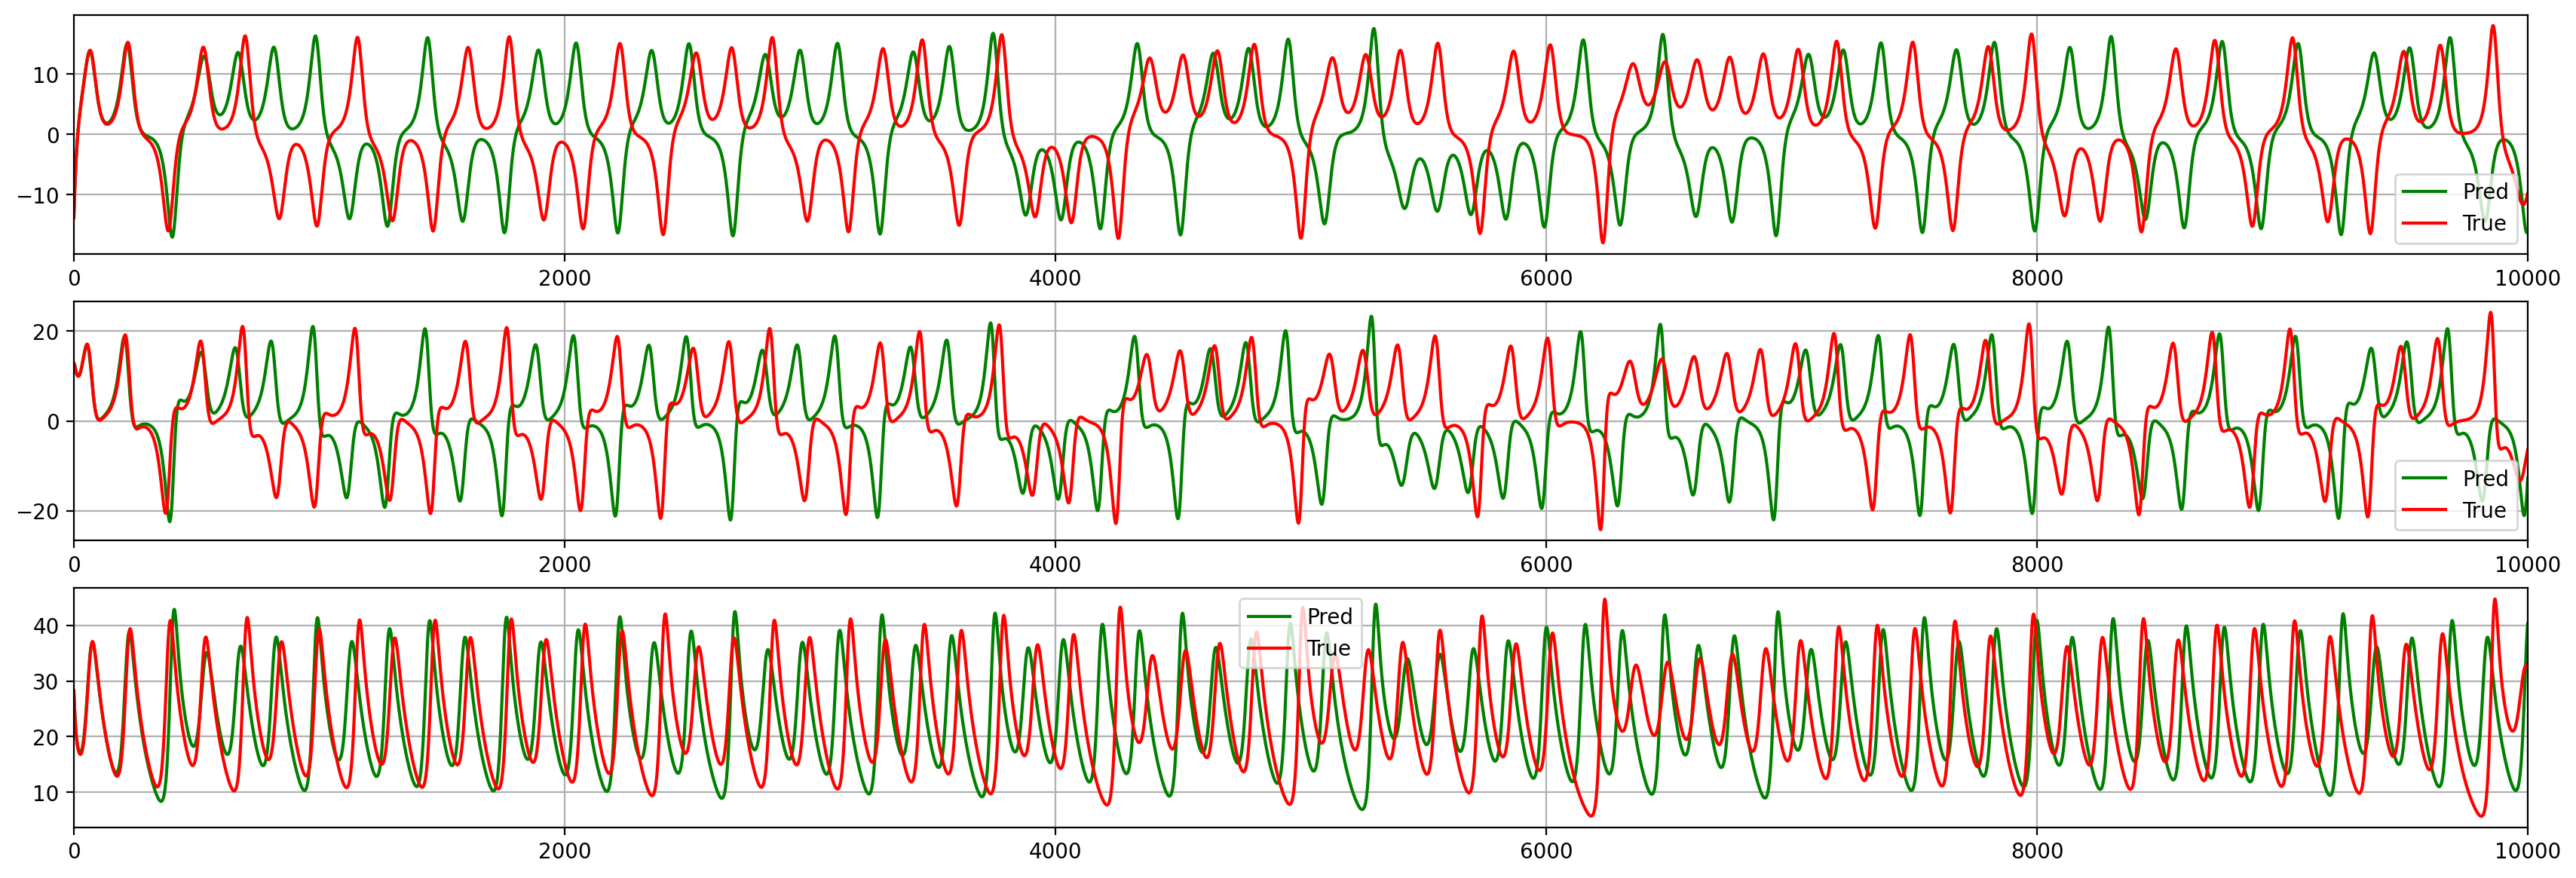

In [142]:
%config InlineBackend.figure_format = 'retina'
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 21
fig_size[1] = 7
plt.subplot(311)
plt.rcParams["figure.figsize"] = fig_size
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot([i[0] for i in test_pred], color="green", label="Pred")
plt.plot([i[0] for i in test_data0.tolist()], color="red", label="True")
plt.legend()
plt.subplot(312)
plt.rcParams["figure.figsize"] = fig_size
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot([i[1] for i in test_pred], color="green", label="Pred")
plt.plot([i[1] for i in test_data0.tolist()], color="red", label="True")
plt.legend()
plt.subplot(313)
plt.rcParams["figure.figsize"] = fig_size
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot([i[2] for i in test_pred], color="green", label="Pred")
plt.plot([i[2] for i in test_data0.tolist()], color="red", label="True")
plt.legend()
plt.savefig("test1.svg")

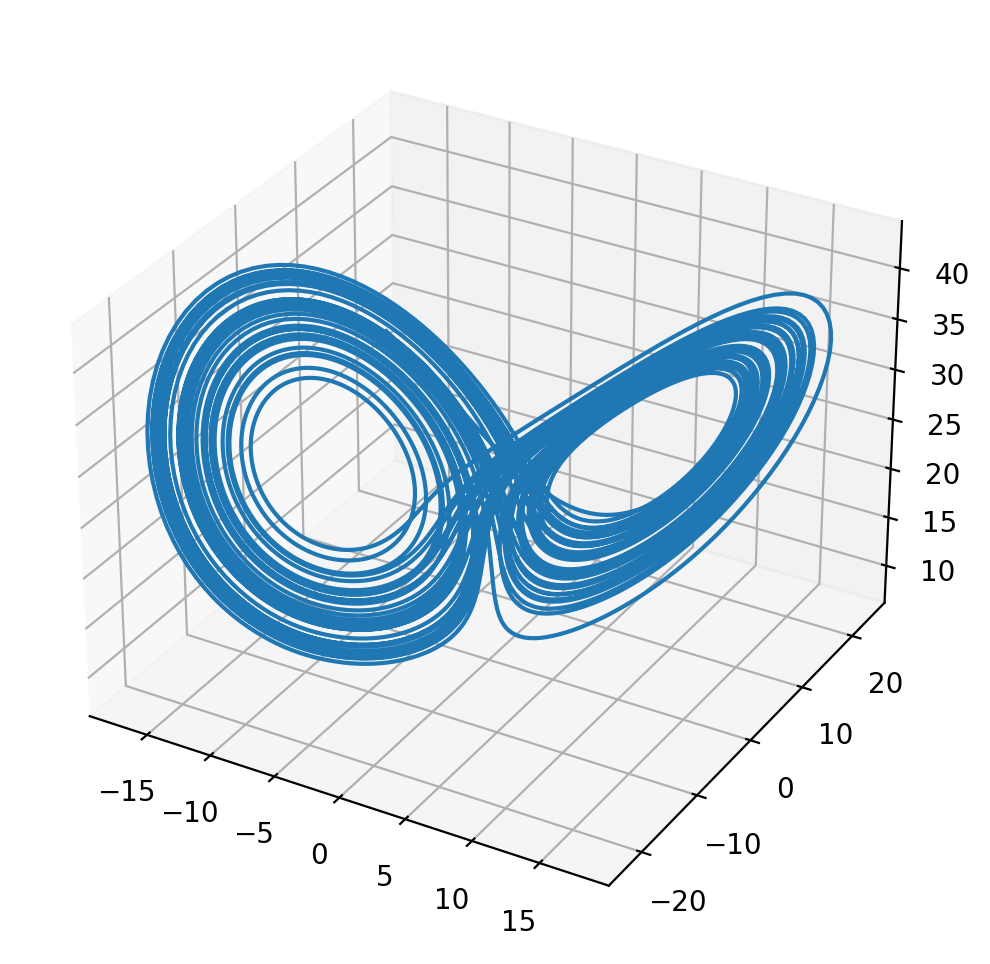

In [143]:
plt.figure(figsize=(12, 6))
ax = plt.axes(projection="3d")
ax.plot([i[0] for i in test_pred],
        [i[1] for i in test_pred],
        [i[2] for i in test_pred],
        )
# ax.plot(
#     [i[0] for i in test_data0.tolist()],
#     [i[1] for i in test_data0.tolist()],
#     [i[2] for i in test_data0.tolist()],
#     color="green"
# )
plt.savefig("test1_3d.svg")